# My Session 3

In [1]:
# First check the Python version
import sys
if sys.version_info < (3,4):
    print('You are running an older version of Python!\n\n' \
          'You should consider updating to Python 3.4.0 or ' \
          'higher as the libraries built for this course ' \
          'have only been tested in Python 3.4 and higher.\n')
    print('Try installing the Python 3.5 version of anaconda '
          'and then restart `jupyter notebook`:\n' \
          'https://www.continuum.io/downloads\n\n')

# Now get necessary libraries
try:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    import IPython.display as ipyd
except ImportError:
    print('You are missing some packages! ' \
          'We will try installing them before continuing!')
    !pip install "numpy>=1.11.0" "matplotlib>=1.5.1" "scikit-image>=0.11.3" "scikit-learn>=0.17" "scipy>=0.17.0"
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    import IPython.display as ipyd
    print('Done!')

# Import Tensorflow
try:
    import tensorflow as tf
except ImportError:
    print("You do not have tensorflow installed!")
    print("Follow the instructions on the following link")
    print("to install tensorflow before continuing:")
    print("")
    print("https://github.com/pkmital/CADL#installation-preliminaries")

# This cell includes the provided libraries from the zip file
# and a library for displaying images from ipython, which
# we will use to display the gif
try:
    from libs import utils, gif, datasets, dataset_utils, vae, dft, tboard
except ImportError:
    print("Make sure you have started notebook in the same directory" +
          " as the provided zip file which includes the 'libs' folder" +
          " and the file 'utils.py' inside of it.  You will NOT be able"
          " to complete this assignment unless you restart jupyter"
          " notebook inside the directory created by extracting"
          " the zip file or cloning the github repo.")

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

# Part One - Autoencoders

In [2]:
def crop_edge(img, cropped_rate):
    """Crop arbitrary amount of pixel.
    """
    row_i = int(img.shape[0] * cropped_rate) // 2
    col_i = int(img.shape[1] * cropped_rate) // 2
    return img[row_i:-row_i, col_i:-col_i]

In [3]:
# See how this works w/ Celeb Images or try your own dataset instead:
dirname = '../data/pokemon/jpeg/'

# Load every image file in the provided directory
filenames = [os.path.join(dirname, fname)
             for fname in os.listdir(dirname)]
# imgs = [plt.imread(fname)[..., :3] for fname in filenames]

imgs = [imresize(crop_edge(plt.imread(f), 0.4), (64, 64)) for f in filenames]
imgs = np.array(imgs)

# Shuffle and limit the number of files to process
nb_clip = 100
np.random.shuffle(imgs)
imgs = imgs[:nb_clip]

# Then convert the list of images to a 4d array (e.g. use np.array to convert a list to a 4d array):
Xs = imgs.reshape(-1, 64, 64, 3 )

print(Xs.shape)
assert(Xs.ndim == 4 and Xs.shape[1] <= 100 and Xs.shape[2] <= 100)

(100, 64, 64, 3)


In [4]:
ds = datasets.Dataset(Xs)

## Normalization

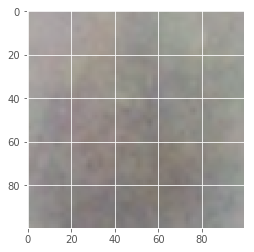

In [5]:
mean_img = ds.mean().astype(np.uint8)
plt.imshow(mean_img)
# If your image comes out entirely black, try w/o the `astype(np.uint8)`
# that means your images are read in as 0-255, rather than 0-1 and 
# this simply depends on the version of matplotlib you are using.

(100, 100, 3)


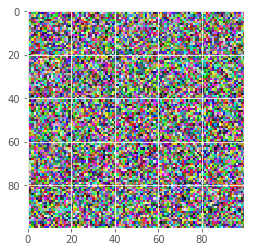

In [6]:
std_img = ds.std()
plt.imshow(std_img)
print(std_img.shape)

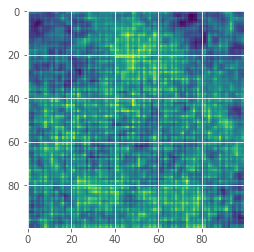

In [7]:
std_img = np.mean(std_img, axis=2)
plt.imshow(std_img)

(100, 100, 100, 3)


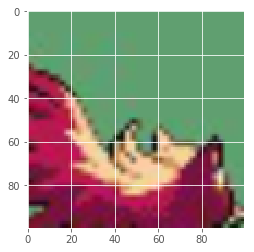

In [8]:
plt.imshow(ds.X[0])
print(ds.X.shape)

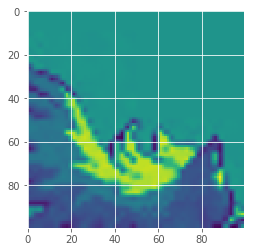

In [9]:
plt.imshow(ds.X[0].mean(axis=2))

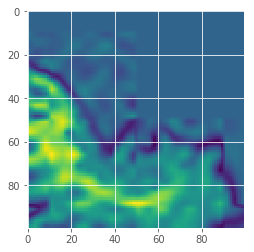

In [10]:
plt.imshow(ds.X[0].std(axis=2))

## Preprocess and deprocess

In [10]:
# Write a function to preprocess/normalize an image, given its dataset object
# (which stores the mean and standard deviation!)
def preprocess(img, ds):
    norm_img = (img - ds.mean()) / ds.std()
    return norm_img

# Write a function to undo the normalization of an image, given its dataset object
# (which stores the mean and standard deviation!)
def deprocess(norm_img, ds):
    img = norm_img * ds.std() + ds.mean()
    return img

In [11]:
nb_features = len(ds.X[0].flatten())
print(nb_features)

30000


In [12]:
64*64*3

12288

In [13]:
encoder_dimensions = [1024, 64, 4]

## Graph time

In [14]:
tf.reset_default_graph()

In [15]:
X = tf.placeholder(np.float32, [None, nb_features])
                   
assert(X.get_shape().as_list() == [None, nb_features])

## Encoder

In [22]:
def encode(X, dimensions, activation=tf.nn.tanh):
    # We're going to keep every matrix we create so let's create a list to hold them all
    Ws = []
    # We'll create a for loop to create each layer:
    for layer_i, nb_output in enumerate(dimensions):

        # TODO: just like in the last session,
        # we'll use a variable scope to help encapsulate our variables
        # This will simply prefix all the variables made in this scope
        # with the name we give it.  Make sure it is a unique name
        # for each layer, e.g., 'encoder/layer1', 'encoder/layer2', or
        # 'encoder/1', 'encoder/2',... 
        with tf.variable_scope('encode/layer{}'.format(layer_i)):

            # TODO: Create a weight matrix which will increasingly reduce
            # down the amount of information in the input by performing
            # a matrix multiplication.  You can use the utils.linear function.
            h, W = utils.linear(X, nb_output, activation=activation)
            
            # TODO: Apply an activation function (unless you used the parameter
            # for activation function in the utils.linear call)

            # Finally we'll store the weight matrix.
            # We need to keep track of all
            # the weight matrices we've used in our encoder
            # so that we can build the decoder using the
            # same weight matrices.
            Ws.append(W)
            
            # Replace X with the current layer's output, so we can
            # use it in the next layer.
            X = h
            print("layer/{}/X".format(layer_i))
            print(X.get_shape())

    z = X
    print("enode/global/X/")
    print(X.get_shape())
    return Ws, z

In [23]:
# Then call the function
Ws, Z = encode(X, encoder_dimensions)

# And just some checks to make sure you've done it right.
# assert(Z.get_shape().as_list() == [None, 2])
# assert(len(Ws) == len(encoder_dimensions))

layer/0/X
(?, 1024)
layer/1/X
(?, 64)
layer/2/X
(?, 4)
enode/global/X/
(?, 4)


In [24]:
[W_i.get_shape().as_list() for W_i in Ws]

[[30000, 1024], [1024, 64], [64, 4]]

In [25]:
Z.get_shape().as_list()

[None, 4]

## Decoder

In [19]:
# We'll first reverse the order of our weight matrices
decoder_Ws = Ws[::-1]

# then reverse the order of our dimensions
# appending the last layers number of inputs.
decoder_dimensions = encoder_dimensions[::-1][1:] + [nb_features]
print(decoder_dimensions)

assert(decoder_dimensions[-1] == nb_features)

[64, 1024, 12288]


In [20]:
def decode(z, dimensions, Ws, activation=tf.nn.tanh):
    current_input = z
    for layer_i, n_output in enumerate(dimensions):
        # we'll use a variable scope again to help encapsulate our variables
        # This will simply prefix all the variables made in this scope
        # with the name we give it.
        with tf.variable_scope("decoder/layer/{}".format(layer_i)):

            # Now we'll grab the weight matrix we created before and transpose it
            # So a 3072 x 784 matrix would become 784 x 3072
            # or a 256 x 64 matrix, would become 64 x 256
            W = tf.transpose(Ws[layer_i])

            # Now we'll multiply our input by our transposed W matrix
            h = tf.matmul(current_input, W)

            # And then use a relu activation function on its output
            current_input = activation(h)

            # We'll also replace n_input with the current n_output, so that on the
            # next iteration, our new number inputs will be correct.
            n_input = n_output
    Y = current_input
    return Y

In [23]:
Y = decode(Z, decoder_dimensions, decoder_Ws)

In [24]:
Y.get_shape().as_list()

[None, 12288]

## Optimizer

In [21]:
# Calculate some measure of loss, e.g. the pixel to pixel absolute difference or squared difference
# loss = tf.reduce_mean(tf.squared_difference(X, Y), 1)
loss = tf.squared_difference(X, Y)
# Now sum over every pixel and then calculate the mean over the batch dimension (just like session 2!)
# hint, use tf.reduce_mean and tf.reduce_sum
cost = tf.reduce_sum(loss)

In [22]:
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate==learning_rate).minimize(cost)

In [23]:
# (TODO) Create a tensorflow session and initialize all of our weights:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

## All aboard the Tensorboard

In [24]:
from libs import tboard
tboard.show_graph(tf.get_default_graph().as_graph_def())

## Training

0 300.447675


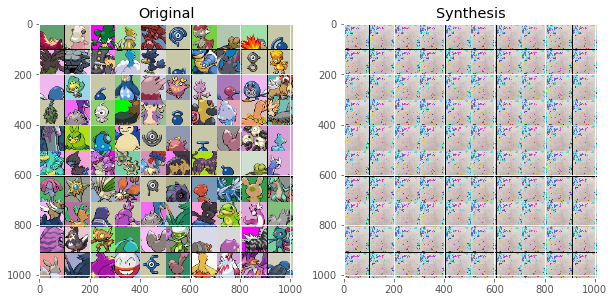

1 410.157975
2 405.348225
3 405.283825
4 405.689875
5 406.4709
6 406.588875
7 406.745425
8 406.814475
9 406.81625
10 406.834625


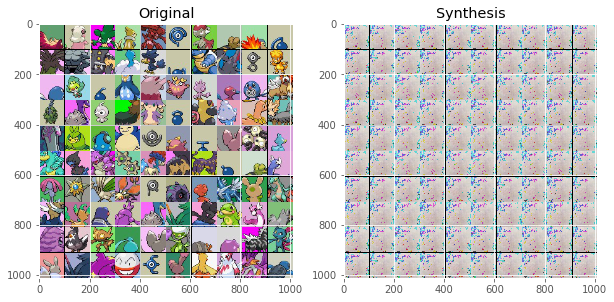

11 407.0781
12 407.11365
13 407.17945
14 407.0805


KeyboardInterrupt: 

In [41]:
# Some parameters for training
batch_size = 100
nb_epochs = 401
step = 10

# We'll try to reconstruct the same first 100 images and show how
# The network does over the course of training.
examples = ds.X[:100]

# We have to preprocess the images before feeding them to the network.
# I'll do this once here, so we don't have to do it every iteration.
test_examples = preprocess(examples, ds).reshape(-1, nb_features)

# If we want to just visualize them, we can create a montage.
test_images = utils.montage(examples).astype(np.uint8)

# Store images so we can make a gif
gifs = []

# Now for our training:
for epoch_i in range(nb_epochs):
    
    # Keep track of the cost
    this_cost = 0
    
    # Iterate over the entire dataset in batches
    for batch_X, _ in ds.train.next_batch(batch_size=batch_size):
        
        # (TODO) Preprocess and reshape our current batch, batch_X:
        this_batch = preprocess(batch_X, ds).reshape(-1, nb_features)
        
        # Compute the cost, and run the optimizer.
        this_cost += sess.run([cost, optimizer], feed_dict={X: this_batch})[0]
    
    # Average cost of this epoch
    avg_cost = this_cost / ds.X.shape[0] / batch_size
    print(epoch_i, avg_cost)
    
    # Let's also try to see how the network currently reconstructs the input.
    # We'll draw the reconstruction every `step` iterations.
    if epoch_i % step == 0:
        
        # (TODO) Ask for the output of the network, Y, and give it our test examples
        recon = sess.run(Y, feed_dict={X: batch_X.reshape(-1, nb_features)})
                         
        # Resize the 2d to the 4d representation:
        rsz = recon.reshape(examples.shape)

        # We have to unprocess the image now, removing the normalization
        unnorm_img = deprocess(rsz, ds)
                         
        # Clip to avoid saturation
        # TODO: Make sure this image is the correct range, e.g.
        # for float32 0-1, you should clip between 0 and 1
        # for uint8 0-255, you should clip between 0 and 255!
        clipped = np.clip(unnorm_img, 0, 255)

        # And we can create a montage of the reconstruction
        recon = utils.montage(clipped).astype(np.uint8)
        
        # Store for gif
        gifs.append(recon)

        fig, axs = plt.subplots(1, 2, figsize=(10, 10))
        axs[0].imshow(test_images)
        axs[0].set_title('Original')
        axs[1].imshow(recon)
        axs[1].set_title('Synthesis')
        fig.canvas.draw()
        plt.show()

# Alternate

In [1]:
# First check the Python version
import sys
if sys.version_info < (3,4):
    print('You are running an older version of Python!\n\n' \
          'You should consider updating to Python 3.4.0 or ' \
          'higher as the libraries built for this course ' \
          'have only been tested in Python 3.4 and higher.\n')
    print('Try installing the Python 3.5 version of anaconda '
          'and then restart `jupyter notebook`:\n' \
          'https://www.continuum.io/downloads\n\n')

# Now get necessary libraries
try:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    import IPython.display as ipyd
except ImportError:
    print('You are missing some packages! ' \
          'We will try installing them before continuing!')
    !pip install "numpy>=1.11.0" "matplotlib>=1.5.1" "scikit-image>=0.11.3" "scikit-learn>=0.17" "scipy>=0.17.0"
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    import IPython.display as ipyd
    print('Done!')

# Import Tensorflow
try:
    import tensorflow as tf
except ImportError:
    print("You do not have tensorflow installed!")
    print("Follow the instructions on the following link")
    print("to install tensorflow before continuing:")
    print("")
    print("https://github.com/pkmital/CADL#installation-preliminaries")

# This cell includes the provided libraries from the zip file
# and a library for displaying images from ipython, which
# we will use to display the gif
try:
    from libs import utils, gif, datasets, dataset_utils, vae, dft
except ImportError:
    print("Make sure you have started notebook in the same directory" +
          " as the provided zip file which includes the 'libs' folder" +
          " and the file 'utils.py' inside of it.  You will NOT be able"
          " to complete this assignment unless you restart jupyter"
          " notebook inside the directory created by extracting"
          " the zip file or cloning the github repo.")

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

## Load

In [2]:
def crop_edge(img, cropped_rate):
    """Crop arbitrary amount of pixel.
    """
    row_i = int(img.shape[0] * cropped_rate) // 2
    col_i = int(img.shape[1] * cropped_rate) // 2
    return img[row_i:-row_i, col_i:-col_i]

(100, 100, 100, 3)


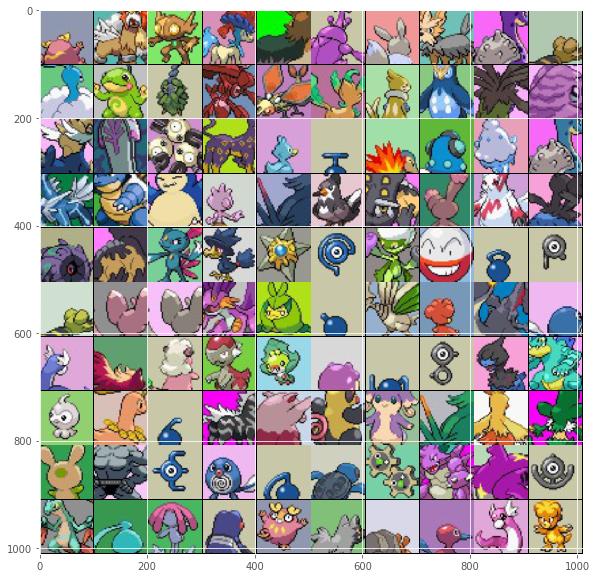

In [26]:
# See how this works w/ Celeb Images or try your own dataset instead:
filenames = [os.path.join('../data/pokemon/jpeg/', file_i)
              for file_i in os.listdir('../data/pokemon/jpeg/')
              if '.jpg' in file_i]

nb_clip = 100
filenames = filenames[:nb_clip]
imgs = [imresize(crop_edge(plt.imread(f), 0.4), (100, 100)) for f in filenames]

# Then convert the list of images to a 4d array (e.g. use np.array to convert a list to a 4d array):
Xs = np.array(imgs)

print(Xs.shape)
assert(Xs.ndim == 4 and Xs.shape[1] <= 250 and Xs.shape[2] <= 250)

plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(imgs).astype(np.uint8))

In [27]:
ds = datasets.Dataset(Xs)

(100, 100, 3)


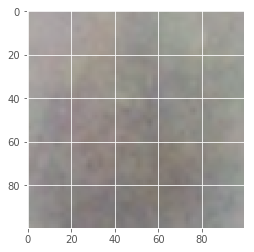

In [28]:
mean_img = ds.mean().astype(np.uint8)
plt.imshow(mean_img)
print(ds.mean().shape)

(100, 100, 3)


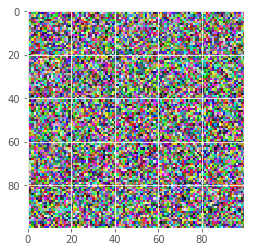

In [29]:
std_img = ds.std() #.astype(np.uint8)
plt.imshow(std_img)
print(std_img.shape)

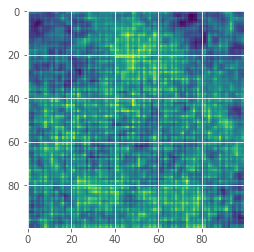

In [30]:
std_img = np.mean(std_img, axis=2)
plt.imshow(std_img)

(100, 100, 3)
(100, 100, 100, 3)


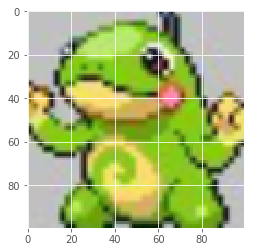

In [31]:
plt.imshow(ds.X[0])
print(ds.X[0].shape)
print(ds.X.shape)

In [32]:
for (X, y) in ds.train.next_batch(batch_size=10):
    print(X.shape)

(10, 100, 100, 3)
(10, 100, 100, 3)
(10, 100, 100, 3)
(10, 100, 100, 3)
(10, 100, 100, 3)
(10, 100, 100, 3)
(10, 100, 100, 3)
(10, 100, 100, 3)
(10, 100, 100, 3)
(10, 100, 100, 3)


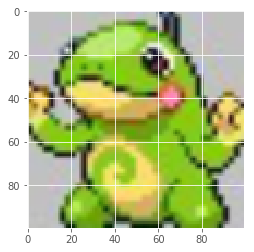

In [33]:
# Write a function to preprocess/normalize an image, given its dataset object
# (which stores the mean and standard deviation!)
def preprocess(img, ds):
    norm_img = (img - ds.mean()) / ds.std()
    return norm_img

# Write a function to undo the normalization of an image, given its dataset object
# (which stores the mean and standard deviation!)
def deprocess(norm_img, ds):
    img = norm_img * ds.std() + ds.mean()
    return img

# Just to make sure that you've coded the previous two functions correctly:
assert(np.allclose(deprocess(preprocess(ds.X[0], ds), ds), ds.X[0]))
plt.imshow(deprocess(preprocess(ds.X[0], ds), ds).astype(np.uint8))

In [34]:
# Calculate the number of features in your image.
# This is the total number of pixels, or (height x width x channels).
height = ds.X[0].shape[0]
width = ds.X[0].shape[1]
channels = ds.X[0].shape[2]

n_features = height * width * channels
print(n_features)

30000


In [35]:
# encoder_dimensions = [1024, 256, 64, 2]

encoder_dimensions = [1024, 64, 16, 2]
# encoder_dimensions = [1024, 64, 4]
# encoder_dimensions = [1024, 512, 256, 128, 64, 32, 16, 8]

In [36]:
tf.reset_default_graph()

In [37]:
X = tf.placeholder(tf.float32, shape = (None, n_features), name = "X")
                   
assert(X.get_shape().as_list() == [None, n_features])

In [38]:
def encode(X, dimensions, activation=tf.nn.tanh):
    # We're going to keep every matrix we create so let's create a list to hold them all
    Ws = []

    # We'll create a for loop to create each layer:
    for layer_i, n_output in enumerate(dimensions):

        # This will simply prefix all the variables made in this scope
        # with the name we give it.  Make sure it is a unique name
        # for each layer, e.g., 'encoder/layer1', 'encoder/layer2', or
        # 'encoder/1', 'encoder/2',... 
        with tf.variable_scope("encode/layer" + str(layer_i + 1)):

            # Create a weight matrix which will increasingly reduce
            # down the amount of information in the input by performing
            # a matrix multiplication.  You can use the utils.linear function.
            h, W = utils.linear(X, dimensions[layer_i])

            # Finally we'll store the weight matrix.
            # We need to keep track of all
            # the weight matrices we've used in our encoder
            # so that we can build the decoder using the
            # same weight matrices.
            Ws.append(W)
            
            # Replace X with the current layer's output, so we can
            # use it in the next layer.
            X = h
    
    z = X
    return Ws, z

In [39]:
# Then call the function
Ws, z = encode(X, encoder_dimensions)

# And just some checks to make sure you've done it right.
# assert(z.get_shape().as_list() == [None, 2])
# assert(len(Ws) == len(encoder_dimensions))

In [40]:
# We'll first reverse the order of our weight matrices
decoder_Ws = Ws[::-1]

# then reverse the order of our dimensions
# appending the last layers number of inputs.
decoder_dimensions = encoder_dimensions[::-1][1:] + [n_features]
print(decoder_dimensions)

assert(decoder_dimensions[-1] == n_features)

[16, 64, 1024, 30000]


In [41]:
def decode(z, dimensions, Ws, activation=tf.nn.tanh):
    current_input = z
    for layer_i, n_output in enumerate(dimensions):
        # we'll use a variable scope again to help encapsulate our variables
        # This will simply prefix all the variables made in this scope
        # with the name we give it.
        with tf.variable_scope("decoder/layer/{}".format(layer_i)):

            # Now we'll grab the weight matrix we created before and transpose it
            # So a 3072 x 784 matrix would become 784 x 3072
            # or a 256 x 64 matrix, would become 64 x 256
            W = tf.transpose(Ws[layer_i])

            # Now we'll multiply our input by our transposed W matrix
            h = tf.matmul(current_input, W)

            # And then use a relu activation function on its output
            current_input = activation(h)

            # We'll also replace n_input with the current n_output, so that on the
            # next iteration, our new number inputs will be correct.
            n_input = n_output
    Y = current_input
    return Y

In [42]:
Y = decode(z, decoder_dimensions, decoder_Ws)

In [43]:
Y.get_shape().as_list()

[None, 30000]

In [44]:
# Calculate some measure of loss, e.g. the pixel to pixel absolute difference or squared difference
loss = tf.squared_difference(X, Y)

# Now sum over every pixel and then calculate the mean over the batch dimension (just like session 2!)
# hint, use tf.reduce_mean and tf.reduce_sum
cost = tf.reduce_sum(loss)

In [45]:
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [46]:
from libs import tboard
tboard.show_graph(tf.get_default_graph().as_graph_def())

Instructions for updating:
Use `tf.global_variables_initializer` instead.
0 300.2403


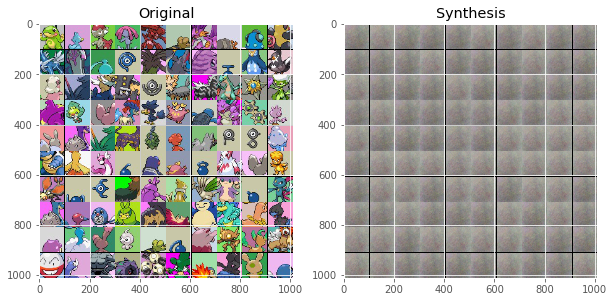

1 282.707075
2 264.75035
3 253.6181
4 251.65685
5 251.079975
6 249.609425
7 248.660575
8 246.676875
9 245.846675
10 244.926075


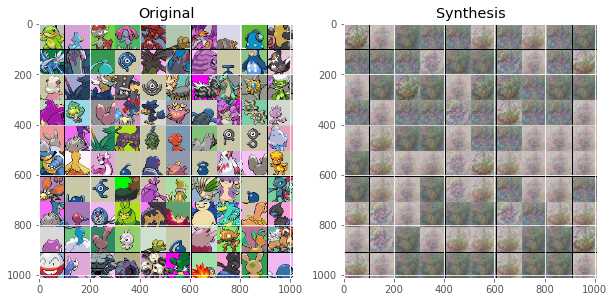

11 243.7456
12 243.290575
13 244.518725
14 247.385875
15 249.573975
16 249.1024
17 246.23315
18 242.53935
19 242.427375
20 243.477425


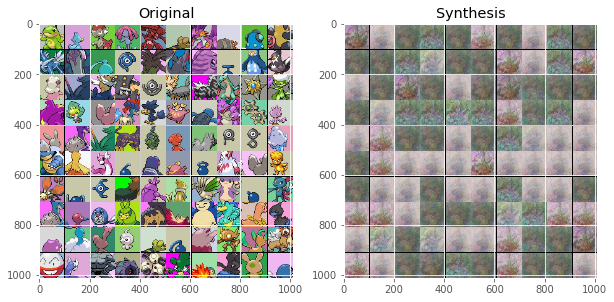

21 244.8294
22 245.487075
23 246.88805
24 246.940925
25 246.482975
26 245.923825
27 244.16025
28 243.15415
29 241.226
30 240.186475


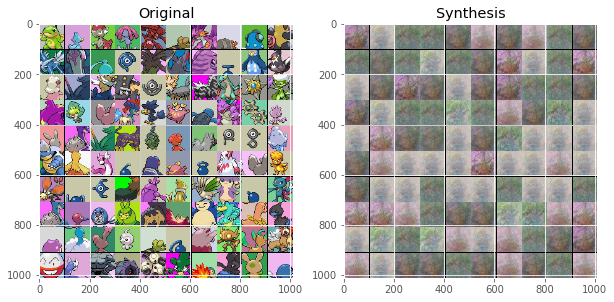

31 239.38255
32 239.21645
33 239.081525
34 239.5312
35 239.302875
36 239.0794
37 238.33355
38 237.667225
39 236.5672
40 236.067925


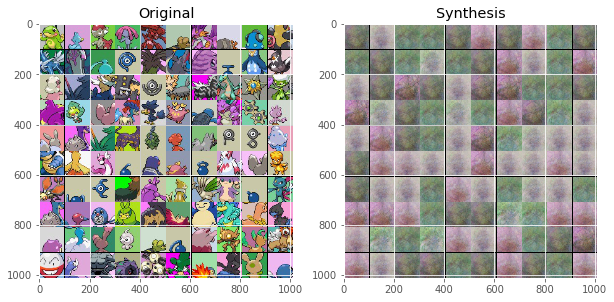

In [48]:
# Create a tensorflow session and initialize all of our weights:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

# Some parameters for training
batch_size = 100
n_epochs = 41
step = 10

# We'll try to reconstruct the same first 100 images and show how
# The network does over the course of training.
examples = ds.X[:100]

# We have to preprocess the images before feeding them to the network.
# I'll do this once here, so we don't have to do it every iteration.
test_examples = preprocess(examples, ds).reshape(-1, n_features)

# If we want to just visualize them, we can create a montage.
test_images = utils.montage(examples).astype(np.uint8)

# Store images so we can make a gif
gifs = []

# Now for our training:
for epoch_i in range(n_epochs):
    
    # Keep track of the cost
    this_cost = 0
    
    # Iterate over the entire dataset in batches
    for batch_X, _ in ds.train.next_batch(batch_size = batch_size):
        
        # Preprocess and reshape our current batch, batch_X:
        this_batch = preprocess(batch_X, ds).reshape(-1, n_features)
        
        # Compute the cost, and run the optimizer.
        this_cost += sess.run([cost, optimizer], feed_dict = {X: this_batch})[0]
    
    # Average cost of this epoch
    avg_cost = this_cost / ds.X.shape[0] / batch_size
    print(epoch_i, avg_cost)
    
    # Let's also try to see how the network currently reconstructs the input.
    # We'll draw the reconstruction every `step` iterations.
    if epoch_i % step == 0:
        
        # Ask for the output of the network, Y, and give it our test examples
        recon = sess.run(Y, feed_dict = {X: test_examples})
                         
        # Resize the 2d to the 4d representation:
        rsz = recon.reshape(examples.shape)

        # We have to unprocess the image now, removing the normalization
        unnorm_img = deprocess(rsz, ds)
                         
        # Clip to avoid saturation
        clipped = np.clip(unnorm_img, 0, 255)

        # And we can create a montage of the reconstruction
        recon = utils.montage(clipped).astype(np.uint8)
        
        # Store for gif
        gifs.append(recon)

        fig, axs = plt.subplots(1, 2, figsize=(10, 10))
        axs[0].imshow(test_images)
        axs[0].set_title('Original')
        axs[1].imshow(recon)
        axs[1].set_title('Synthesis')
        fig.canvas.draw()
        plt.show()

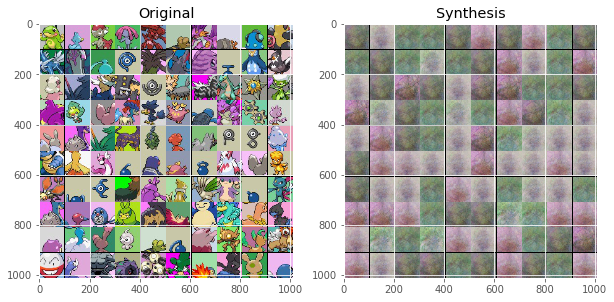

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(test_images)
axs[0].set_title('Original')
axs[1].imshow(recon)
axs[1].set_title('Synthesis')
fig.canvas.draw()
plt.show()
plt.imsave(arr=test_images, fname='test.png')
plt.imsave(arr=recon, fname='recon.png')

In [50]:
zs = sess.run(z, feed_dict={X:test_examples})

In [51]:
zs.shape

(100, 2)

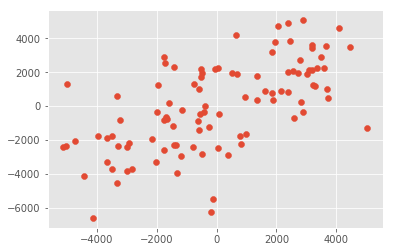

In [52]:
plt.scatter(zs[:, 0], zs[:, 1])

In [53]:
n_images = 100
idxs = np.linspace(np.min(zs) * 2.0, np.max(zs) * 2.0,
                   int(np.ceil(np.sqrt(n_images))))
xs, ys = np.meshgrid(idxs, idxs)
grid = np.dstack((ys, xs)).reshape(-1, 2)[:n_images,:]

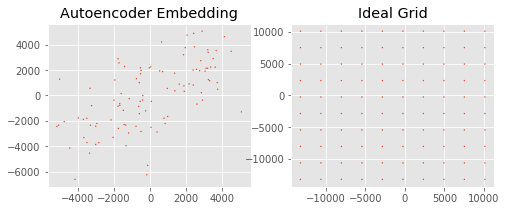

In [54]:
fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].scatter(zs[:, 0], zs[:, 1],
               edgecolors='none', marker='o', s=2)
axs[0].set_title('Autoencoder Embedding')
axs[1].scatter(grid[:,0], grid[:,1],
               edgecolors='none', marker='o', s=2)
axs[1].set_title('Ideal Grid')

In [55]:
from scipy.spatial.distance import cdist
cost = cdist(grid[:, :], zs[:, :], 'sqeuclidean')
from scipy.optimize._hungarian import linear_sum_assignment
indexes = linear_sum_assignment(cost)

In [56]:
indexes

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([63,  4, 95, 74, 21, 97, 93, 22, 26, 19, 14, 15, 75, 92,  9, 29, 25,
        30, 70, 41, 43, 11, 42, 23,  6, 60, 89, 16, 36, 79, 82, 98, 10, 50,
        88, 37, 55, 71, 86, 90, 73, 27,  2, 94,  0, 45,  5, 78, 96, 72,  3,
        87, 69, 28, 32, 54, 44, 64, 58, 51, 12, 66, 33, 35, 67, 59, 85, 40,
        84, 99,  8, 77, 46, 34, 24, 65, 56, 57, 91,  7, 18, 38, 83, 13, 48,
        61, 68, 20,  1, 52, 81, 76, 31, 47, 62, 53, 17, 49, 39, 80]))

In [59]:
min(indexes[1])

0

(3538.3054, 3651.3428)

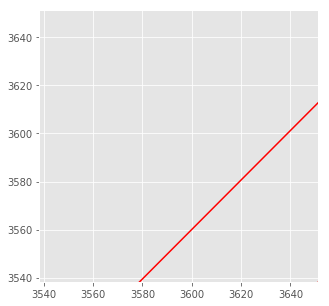

In [62]:
xmin = min(zs[1])
xmax = max(zs[1])
plt.figure(figsize=(5, 5))
for i in range(len(zs)):
    plt.plot([zs[indexes[1][i], 0], grid[i, 0]],
             [zs[indexes[1][i], 1], grid[i, 1]], 'r')
# plt.xlim([-3, 3])
# plt.ylim([-3, 3])

plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])

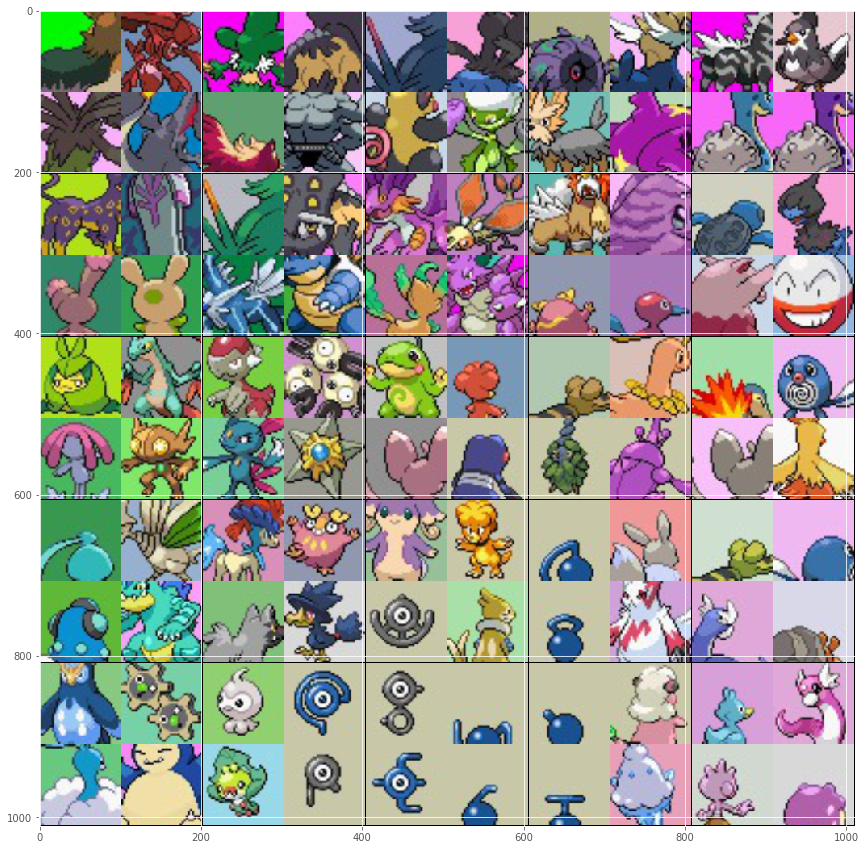

In [63]:
examples_sorted = []
for i in indexes[1]:
    examples_sorted.append(examples[i])
plt.figure(figsize=(15, 15))
img = utils.montage(np.array(examples_sorted)).astype(np.uint8)
plt.imshow(img,
           interpolation='nearest')
plt.imsave(arr=img, fname='sorted.png')

In [69]:
# This is a quick way to do what we could have done as
# a nested for loop:
zs = np.meshgrid(np.linspace(-6000, 6000, 10),
                 np.linspace(-6000, 6000, 10))

# Now we have 100 x 2 values of every possible position
# in a 2D grid from -1 to 1:
zs = np.c_[zs[0].ravel(), zs[1].ravel()]


In [70]:
recon = sess.run(Y, feed_dict={z : zs})

# reshape the result to an image:
rsz = recon.reshape(examples.shape)

# Deprocess the result, unnormalizing it
unnorm_img = deprocess(rsz, ds)

# clip to avoid saturation
clipped = np.clip(unnorm_img, 0, 255)

# Create a montage
img_i = utils.montage(clipped).astype(np.uint8)

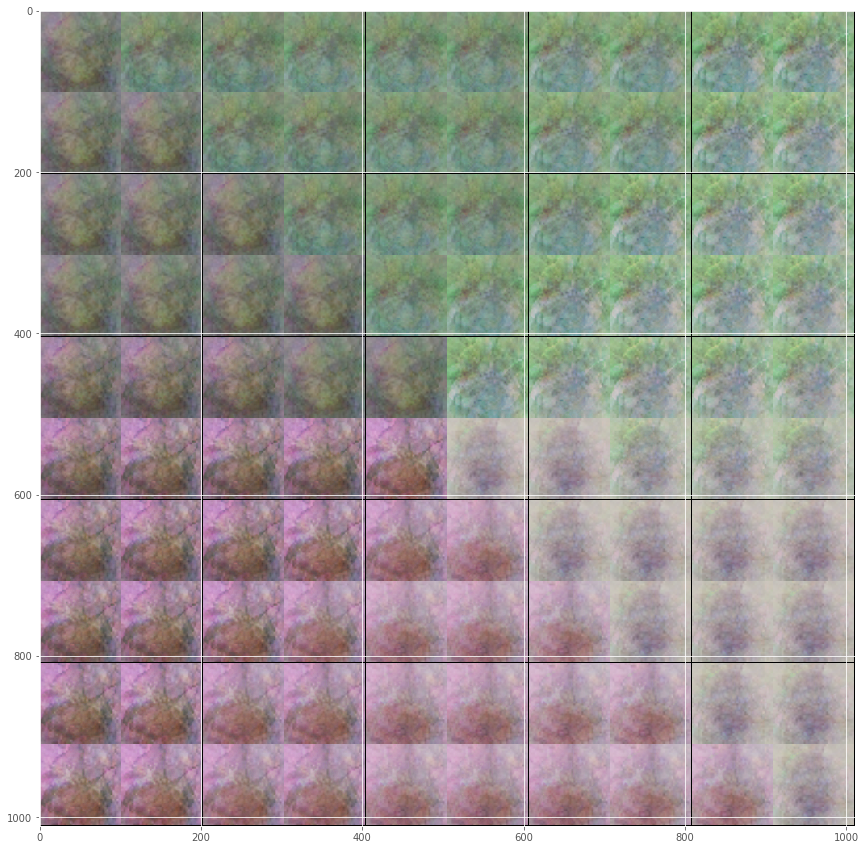

In [71]:
plt.figure(figsize=(15, 15))
plt.imshow(img_i)
plt.imsave(arr=img_i, fname='manifold.png')